In [1]:
# Basic Libraries
import sys
import time
import gc
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")
import cca_core
from netrep.metrics import LinearMetric
import networks as nets  # Contains RNNs
import net_helpers
import tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygofamily' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
# inputadd, Wfix, WL2, hL2
# inputrandom, Wtrain
hyp_dict['addon_name'] = "inputrandom+Wtrain+WL2+hL2"

mpn_depth = 1
n_hidden = 100

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': False, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': True,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False,
        'label_strength': False
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 64,
        'batch_size': 64,
        'gradient_clip': 10,
        'valid_n_batch': 200,
        'n_datasets': 100, # Number of distinct batches
        'n_epochs_per_set': 100, # longer/shorter training
        # 'task_mask': None, # None, task
        'weight_reg': 'L2',
        'activity_reg': 'L2', 
        'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': 100,
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': False, 
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': True,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 400, # ms, sets lambda
            'lam_train': True,
            'W_freeze': False,
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 833
Fixation_off: False; Task_info: True
Rules: ['delaygo', 'delayanti']
  Input size 7, Output size 3
Using CUDA...


In [4]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [5]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim" # or "resp" 

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix)
    _, test_trials, test_rule_idxs = test_trials_extra

    print(test_trials)

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    labels_resp, labels_stim = [], []
    for rule_idx, rule in enumerate(task_params['rules']):
        print(rule)
        if rule in accept_rules:
            if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                labels.append(test_trials[rule_idx].meta['matches'])
            else:
                labels_resp.append(test_trials[rule_idx].meta['resp1'])
                labels_stim.append(test_trials[rule_idx].meta['stim1']) 

        else:
            raise NotImplementedError()
            
    labels_resp = np.concatenate(labels_resp, axis=0).reshape(-1,1)
    labels_stim = np.concatenate(labels_stim, axis=0).reshape(-1,1)

if color_by == "stim":
    labels = labels_stim
else:
    labels = labels_resp
    
test_input, test_output, test_mask = test_data

permutation = np.random.permutation(test_input.shape[0])
test_input = test_input[permutation]
test_output = test_output[permutation]
test_mask = test_mask[permutation]
labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

n_batch_all = test_input_np.shape[0] # Total number of batches, might be different than test_n_batch
max_seq_len = test_input_np.shape[1]

test_task = [] # which task
for batch_idx in range(test_input_np.shape[0]):
    task_label = test_input_np[batch_idx, 0, 6-shift_index:]
    task_label_index = np.where(task_label == 1)[0][0]
    test_task.append(task_label_index)


Align ['delaygo', 'delayanti'] With Same Time
rng reset with seed 5100
rng reset with seed 5100
[<tasks.Trial object at 0x147fae8e2580>, <tasks.Trial object at 0x147fae8e2550>]
delaygo
delayanti


In [6]:
# we use net at different training stage on the same test_input
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst, \
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst) = net_helpers.train_network(params, device=device, verbose=verbose, train=train, hyp_dict=hyp_dict, netFunction=netFunction, test_input=test_input)
counter_lst = [x * epoch_multiply + 1 for x in counter_lst] # avoid log plot issue    

[7, 100, 100, 3]
MultiPlastic Net:
  output neurons: 3
  Act: tanh

=== Layer Universal Setup ===
MPN Layer W Frozen
  MP Layer1 parameters:
    n_neurons - input: 100, output: 100
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (train) // Lambda: scalar (train) // Lambda_max: 0.90 (tau: 4.0e+02)
How about Test Data at dataset 0
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: L2, coef: 1.0e-04
Activity reg: L2, coef: 1.0e-04
Iter: 0, LR: 1.000e-03 - train_loss:3.911e-01, rounded train_acc:0.159, valid_loss:3.336e-01, rounded valid_acc:0.170
Iter: 100, LR: 1.000e-03 - train_loss:1.192e-01, rounded train_acc:0.540, valid_loss:1.924e-01, rounded valid_acc:0.296
How about Test Data at dataset 1
Iter: 200, LR: 1.000e-03 - train_loss:8.073e-02, rounded train_acc:0.611, valid_loss:1.677e-01, rounded valid_acc:0.353

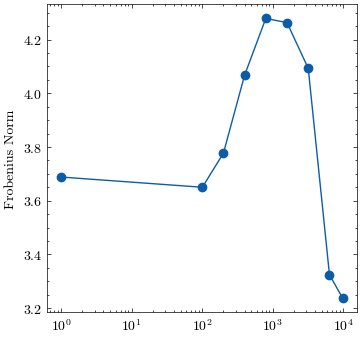

In [7]:
if hyp_dict['chosen_network'] == "dmpn":
    if net_params["input_layer_add"]:
        fignorm, axsnorm = plt.subplots(1,1,figsize=(4,4))
        axsnorm.plot(counter_lst, [np.linalg.norm(Winput_matrix) for Winput_matrix in Winput_lst], "-o")
        axsnorm.set_xscale("log")
        axsnorm.set_ylabel("Frobenius Norm")

In [8]:
# sanity check, if W_freeze, then the recorded W matrix for the modulation layer should not be changed
if net_params["ml_params"]["W_freeze"]: 
    assert np.allclose(Wall_lst[-1][0], Wall_lst[0][0])

if net_params["input_layer_bias"]: 
    assert net_params["input_layer_add"] is True 

Done!


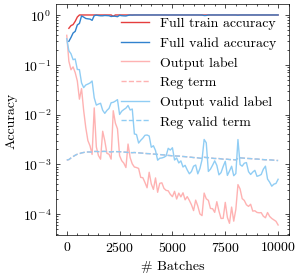

In [9]:
if train:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
    ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    ax.set_yscale('log')
    ax.legend()
    # ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# Batches')
    plt.savefig(f"./twotasks/loss_{hyp_dict['ruleset']}_{task_params['fixate_off']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
    
print('Done!')

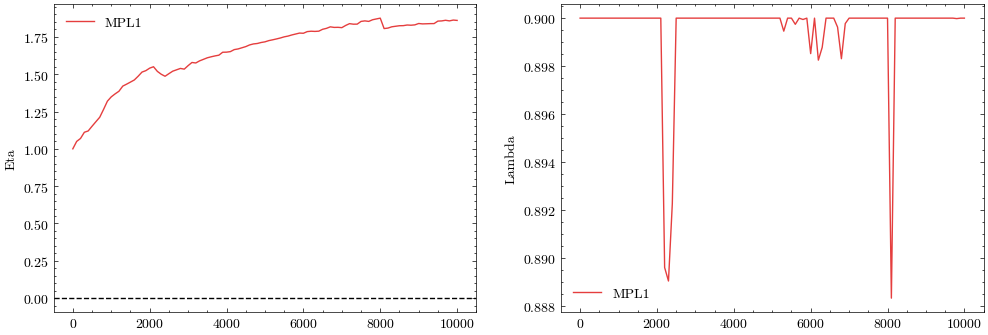

In [10]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Using network at 100.0%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


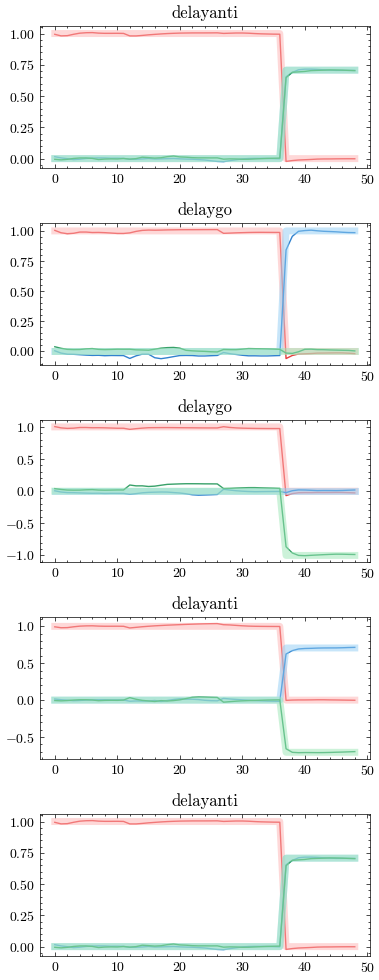

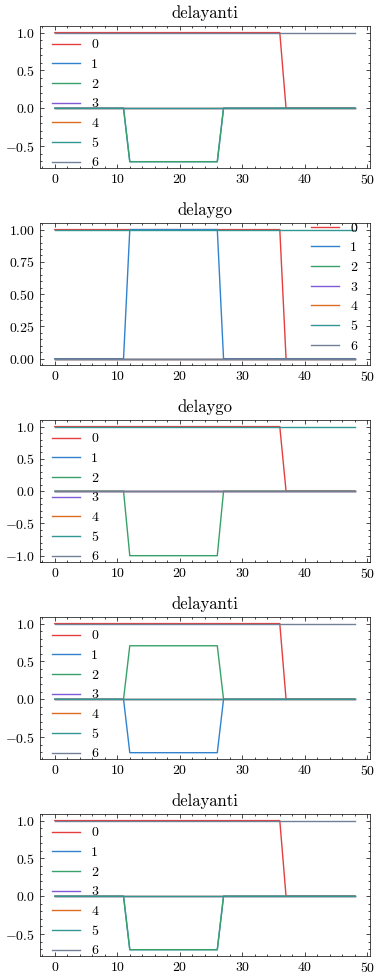

In [11]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    ind = len(marker_lst)-1 
    # ind = 0
    network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    print(f"Using network at {network_at_percent}%")
    net_out = netout_lst[ind]
    db = db_lst[ind]
    W_output = Woutput_lst[ind]
    W_ = Wall_lst[ind][0]

if net_params['loss_type'] in ('MSE',):
    fig, axs = plt.subplots(5, 1, figsize=(4, 5*2))
    figin, axsin = plt.subplots(5, 1, figsize=(4, 5*2))

    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])

    else:
        for batch_idx, ax in enumerate(axs):
            for out_idx in range(test_output_np.shape[-1]):
                axs[batch_idx].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx])
                axs[batch_idx].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                axs[batch_idx].set_title(f"{task_params['rules'][test_task[batch_idx]]}")
                axs[batch_idx].legend()

            input_batch = test_input[batch_idx,:,:].cpu().numpy()
            for inp_idx in range(input_batch.shape[-1]):
                axsin[batch_idx].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                axsin[batch_idx].set_title(f"{task_params['rules'][test_task[batch_idx]]}")
                axsin[batch_idx].legend()

    # fig.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    fig.tight_layout()
    fig.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)


    # figin.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    figin.tight_layout()
    figin.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_input_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [12]:
# here db is selected based on learning stage selection 

layer_index = 0 # 1 layer MPN 
if net_params["input_layer_add"]:
    layer_index += 1 
    
def modulation_extraction(db, layer_index):
    """
    """
    Ms = np.concatenate((
        db[f'M{layer_index}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    Ms_orig = np.concatenate((
        db[f'M{layer_index}'].detach().cpu().numpy(),
    ), axis=-1)

    bs = np.concatenate((
        db[f'b{layer_index}'].detach().cpu().numpy(),
    ), axis=-1) 

    hs = np.concatenate((
        db[f'hidden{layer_index}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    return Ms, Ms_orig, hs, bs
    
if net_params["net_type"] in ("dmpn", ):
    if mpn_depth == 1:
        Ms, Ms_orig, hs, bs = modulation_extraction(db, layer_index)
    else:
        modulations, hiddens = [], []
        for i in range(mpn_depth):
            modulations.append(db[f'M{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1))
            hiddens.append(db[f'hidden{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),)

        Ms = modulations[0]
        hs = hiddens[0]
        
elif net_params["net_type"] in ("vanilla", "gru"):
    hs = db['hidden'].detach().cpu().numpy()

pca_type = 'full' # full, cell_types
pca_target_lst = ['hs', 'Ms'] # hs, 'Ms' 
if net_params["net_type"] in ("vanilla", "gru"):
    pca_target_lst = ['hs'] # if not dmpn, no M information effectively

# using recorded information
recordkyle_all, recordkyle_nameall = [], []
for test_subtrial in test_trials:
    metaepoch = test_subtrial.epochs
    periodname = list(metaepoch.keys())
    recordkyle, recordkyle_name = [], []
    for keyiter in range(len(periodname)):
        try:
            recordkyle_name.append(periodname[keyiter])
            if test_mode_for_all == "random":
                recordkyle.append(metaepoch[periodname[keyiter]][1])
            elif test_mode_for_all == "random_batch":
                recordkyle.append(list(metaepoch[periodname[keyiter]][1]))
        except Exception as e:
            print(e)
    
    if test_mode_for_all in ("random",):
        fillrecordkyle = []
        for timestamp in recordkyle:
            fillrecordkyle.append([timestamp for _ in range(hs.shape[0])])
        recordkyle = fillrecordkyle

    recordkyle.insert(0, [0 for _ in range(len(recordkyle[1]))])
    recordkyle = np.array(recordkyle).T.tolist()
    recordkyle_all.extend(recordkyle)
    recordkyle_nameall.append(recordkyle_name)

In [13]:
# Sep 30th
# This part of code should be adaptive for multitask, which may have different breaks and periods for each task
unique_lists = set(tuple(lst) for lst in recordkyle_all)
# here select task specific information
# which maximally should have length of number of tasks
unique_recordkyle_all = [list(lst) for lst in unique_lists]
if not task_random_fix:
    assert len(unique_recordkyle_all) >= len(rules_dict[hyp_dict['ruleset']])
else:
    print("Test DataSet Random Seed Is Fixed")

all_session_breakdown = []
for task_specific_time in unique_recordkyle_all:
    session_breakdown = []
    for sindex in range(0,len(task_specific_time)-1):
        # all sessions should be the same for each task
        # but different across tasks
        # though the time of when response period starts might be similar across
        session_breakdown.append([task_specific_time[sindex], task_specific_time[sindex+1]]) 
    session_breakdown.append([task_specific_time[0], task_specific_time[-1]])
    all_session_breakdown.append(session_breakdown)

# break down time
all_breaks = []
for session_breakdown in all_session_breakdown:
    breaks = [cut[1] for cut in session_breakdown[:-1]]
    print(f"Task {all_session_breakdown.index(session_breakdown)}; breaks: {breaks}")
    all_breaks.append(breaks)

# for delay-task
assert len(all_breaks)
response_start = all_breaks[0][-2]
stimulus_start = all_breaks[0][0]
stimulus_end = all_breaks[0][1]
print(f"response_start: {response_start}")
print(f"stimulus_start: {stimulus_start}")
print(f"stimulus_end: {stimulus_end}")

Test DataSet Random Seed Is Fixed
Task 0; breaks: [12, 27, 37, 49]
response_start: 37
stimulus_start: 12
stimulus_end: 27


In [14]:
stages_num = len(Wall_lst) # how many recorded neurons in total
break_info = all_breaks[0]

input_nums = Ms_orig.shape[-1]
batch_nums = Ms_orig.shape[0]
neuron_nums = Ms_orig.shape[2]
colors = helper.generate_rainbow_colors(Ms_orig.shape[2])

def generate_random_orthonormal_matrix(N, num_columns=3):
    """
    generates an N x num_columns random matrix with orthonormal columns.
    """
    random_matrix = np.random.randn(N, num_columns)    
    Q, R = np.linalg.qr(random_matrix)    
    return Q[:, :num_columns]

In [15]:
label_task_comb = []
for i in range(len(labels)):
    label_task_comb.append([labels[i][0], test_task[i]])
label_task_comb_arr = np.array(label_task_comb)

In [16]:
# sanity check from equation 2-7
def plot_trajectory_by_index(label_index, stage_iter, verbose=False):
    """
    """
    W_ = Wall_lst[stage_iter][0]
    W_input = Winput_lst[stage_iter] if net_params["input_layer_add"] else np.ones((test_input.shape[-1], n_hidden))
    W_inputbias = Winputbias_lst[stage_iter] if net_params["input_layer_bias"] else np.zeros((W_input.shape[0],1))
    W_output = Woutput_lst[stage_iter]
    _, Ms_orig, _, bs = modulation_extraction(db_lst[stage_iter], layer_index) # batch * seq_len * hidden_neuron * input_neuron

    if verbose:
        figsize1, figsize2 = 2, 6
        figexh1, axsexh1 = plt.subplots(3,3,figsize=(figsize2*3,figsize1*3))  
        figexh2, axsexh2 = plt.subplots(4,3,figsize=(figsize2*3,figsize1*4))  
        figdiff, axsdiff = plt.subplots(1,2,figsize=(4*2,2))

    task_middle_dict = {}
    task_labels_across_batch = []

    saver_shape1 = (3,3)
    saver1 = np.empty((test_input.shape[0], saver_shape1[0], saver_shape1[1]), dtype=object)
    saver_shape2 = (4,3)
    saver2 = np.empty((test_input.shape[0], saver_shape2[0]+1, saver_shape2[1]), dtype=object)
    saver2_random = np.empty((test_input.shape[0], saver_shape2[0]+1, saver_shape2[1]), dtype=object) # projection to random space

    random_output_Y_lst = [generate_random_orthonormal_matrix(W_output.shape[1]) for _ in range(10)]

    for batch_iter in range(test_input.shape[0]):
        writeon = 0
        labels_for_batch = labels[batch_iter,0]
        
        if labels_for_batch in label_index: # >=0: for all label; ==0, say, for specific label on the ring (regardless on which task is using)
            xx = test_input[batch_iter, :, :].cpu().numpy()[0,6-shift_index:]
            which_task = np.where(xx)[0][0] # extract here, will repeat later at different time slices
            
            if labels_for_batch not in task_middle_dict.keys():
                task_middle_dict[which_task] = []
                writeon = 1
                
            x_batch_taskinfo = test_input[batch_iter, :, :][:,6-shift_index:].cpu().numpy()[0,:]
            # based on the input info, which task is used 
            task_specific = np.where(x_batch_taskinfo == 1)[0]
            assert len(task_specific) == 1
            task_specific = task_specific[0]
            
            task_labels_across_batch.append(task_specific) # load task information (which task) across batches
        
            res_eq26, res_eq8, res_eq11 = [], [], []
            res_meta = []

            for i in range(saver_shape1[0]):
                for j in range(saver_shape1[1]):
                    saver1[batch_iter, i, j] = np.array([])
        
            for i in range(saver_shape2[0]+1):
                for j in range(saver_shape2[1]):
                    saver2[batch_iter, i, j] = np.array([])
                    saver2_random[batch_iter, i, j] = np.array([])
        
            for time_iter in range(test_input.shape[1]):
                x = test_input[batch_iter, time_iter, :].cpu().numpy().reshape(-1,1)
                
                input_length = len(x)
        
                x_fixon, x_fixoff, x_stimulus, x_task = [np.zeros((input_length, 1)) for _ in range(4)]
                # one-hot encoded vector for fixation
                x_fixon[0,0] = x[0,0] 
                # one-hot encoded vector for fixation off (set to dummy if not presented)
                x_fixoff[1,0] = x[1,0] if task_params['fixate_off'] else 0
                # one-hot encoded vector for stimulus
                x_stimulus[2-shift_index:6-shift_index,0] = x[2-shift_index:6-shift_index,0]
                # one-hot encoded vector for task
                # task (dynamically setting for all element after the 6th elements)
                tasks_info = x[6-shift_index:,0]
                x_task[6-shift_index:,0] = tasks_info

                which_task = np.where(tasks_info)[0][0]
                
                Mt = Ms_orig[batch_iter, time_iter, :, :] 
                bt = bs[batch_iter, time_iter, :].reshape(-1,1) # hidden_neuron * 1
                
                middle =  W_ + W_ * Mt

                if time_iter >= response_start + 1 and len(label_index) == 1:
                    if writeon:
                        task_middle_dict[which_task].append(middle)
                
                y_fix = W_output[0,:].reshape(1,-1)
                Y_resp1 = W_output[1,:].reshape(1,-1)
                Y_resp2 = W_output[2,:].reshape(1,-1)

                if task_params['fixate_off']:
                    allX1 = [x_fixon+x_task, x_fixoff+x_task, x_stimulus+x_fixon+x_task]
                else:
                    allX1 = [x_fixon+x_task, x_task, x_stimulus+x_fixon+x_task]

                def process_x_add_input(x):
                    if net_params["input_layer_add"]:
                        x = W_input @ x  
                    if net_params["input_layer_bias"]:
                        x = x + W_inputbias
                    return x
                
                allX1name = ["x_fixon+x_task", "x_fixoff+x_task", "x_stimulus+x_fixon+x_task"]
                allX2 = [x_fixon, x_fixoff, x_stimulus, x_task]
                allX2name = ["x_fixon", "x_fixoff", "x_stimulus", "x_task"]
                allY = [y_fix, Y_resp1, Y_resp2]
                allYname = ["y_fix", "Y_resp1", "Y_resp2"]

                allX1 = [process_x_add_input(x) for x in allX1]
                allX2 = [process_x_add_input(x) for x in allX2]
        
                for yiter in range(len(allY)):
                    for xiter in range(len(allX1)):
                        # res1 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX1[xiter])
                        step1 = middle @ allX1[xiter] + bt # adjust according to specific bias 
                        res1 = allY[yiter] @ step1 
                        saver1[batch_iter, xiter, yiter] = np.append(saver1[batch_iter, xiter, yiter], res1[0,0])
        
                for y1 in range(len(allY)):
                    for x1 in range(len(allX2)):
                        # res2 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX2[xiter])
                        step1 = middle @ allX2[x1]
                        res2 = allY[y1] @ step1
                        res2_random = [((random_output_Y[:,y1].reshape(1,-1)) @ middle @ allX2[x1])[0,0] for random_output_Y in random_output_Y_lst]
                        
                        saver2[batch_iter, x1, y1] = np.append(saver2[batch_iter, x1, y1], res2[0,0])
                        saver2_random[batch_iter, x1, y1] = np.append(saver2_random[batch_iter, x1, y1], np.mean(res2_random))

                # how about bias projection to output
                for y_iter2 in range(len(allY)):
                    step1 = bt 
                    res2 = allY[y_iter2] @ step1
                    saver2[batch_iter, len(allX2), y_iter2] = np.append(saver2[batch_iter, len(allX2), y_iter2], res2[0,0])

            if verbose:
                for i in range(saver_shape1[0]):
                    for j in range(saver_shape1[1]):
                        axsexh1[i,j].plot(saver1[batch_iter,i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
            
                for i in range(saver_shape2[0]):
                    for j in range(saver_shape2[1]):            
                        axsexh2[i,j].plot(saver2[batch_iter,i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
        
                # # extract fixon-task information explicitly
                axsdiff[0].plot(saver2[batch_iter,0,1] + saver2[batch_iter,3,1], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
                axsdiff[0].plot(saver2_random[batch_iter,0,1] + saver2_random[batch_iter,3,1], color=c_vals_l[labels_for_batch], linestyle=l_vals[task_specific])
                
                axsdiff[1].plot(saver2[batch_iter,0,2] + saver2[batch_iter,3,2], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
                axsdiff[1].plot(saver2_random[batch_iter,0,2] + saver2_random[batch_iter,3,2], color=c_vals_l[labels_for_batch], linestyle=l_vals[task_specific])

    if verbose:
        # plot fixon/task information for one specific stimulus on one figure
        # show perfect cancellation until fixon info goes away (during response period)
        figpaper, axspaper = plt.subplots(8,1,figsize=(4, figsize1*8))

        temp_saver = []

        for batch_iter in range(test_input.shape[0]):
            labels_for_batch = labels[batch_iter, 0]
            task_for_batch = task_labels_across_batch[batch_iter]
            if labels_for_batch in label_index and (labels_for_batch, task_for_batch) not in temp_saver:
                f_fixon, f_task, f_bias = saver2[batch_iter, 0, 1], saver2[batch_iter, 3, 1], saver2[batch_iter, -1, 1]
                axspaper[labels_for_batch].plot(f_fixon, color=c_vals[0], linestyle=l_vals[task_for_batch], label=f"Fixon {task_for_batch}")
                axspaper[labels_for_batch].plot(f_task+f_bias, color=c_vals[1], linestyle=l_vals[task_for_batch], label=f"Task+Bias {task_for_batch}")
                axspaper[labels_for_batch].plot(f_fixon+f_task+f_bias, color=c_vals[2], linestyle=l_vals[task_for_batch], linewidth=3, \
                                                       label=f"Combine {task_for_batch}")
                axspaper[labels_for_batch].axhline(0, color=c_vals[3])
                axspaper[labels_for_batch].set_title(f"Stimulus Label {labels_for_batch}")

                temp_saver.append((labels_for_batch, task_for_batch))

        for axsp in axspaper:
            axsp.legend()
            axsp.set_ylim([-2.0, 2.0])
        figpaper.tight_layout()   
        figpaper.savefig(f"./twotasks/show_{hyp_dict['addon_name']}.png", dpi=300)
        
        for i in range(saver_shape1[0]):
            for j in range(saver_shape1[1]):
                axsexh1[i,j].set_ylim([-2.0, 2.0])
                axsexh1[i,j].set_title(f"{allX1name[i]} & {allYname[j]}")
        
        for i in range(saver_shape2[0]):
            for j in range(saver_shape2[1]):
                axsexh2[i,j].set_ylim([-2.0, 2.0])
                axsexh2[i,j].set_title(f"{allX2name[i]} & {allYname[j]}")
        
        for ax in np.concatenate((axsexh1.flatten(), axsexh2.flatten())):
            for breaks in all_breaks:
                for bb in breaks:
                    ax.axvline(bb, linestyle="--", c=c_vals[all_breaks.index(breaks)])
    
        label_index_name = "all" if len(label_index) == 8 else label_index
        
        figexh1.suptitle(f"Exhaustive Search 1 {color_by} at Stage {stage_iter}")
        figexh1.tight_layout()
        # figexh1.savefig(f"./twotasks/es1_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
        figexh2.suptitle(f"Exhaustive Search 2 {color_by} Stage {stage_iter}")
        figexh2.tight_layout()
        # figexh2.savefig(f"./twotasks/es2_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        axsdiff[0].set_title("Stimulus 1")
        axsdiff[1].set_title("Stimulus 2")
        figdiff.suptitle(f"Fixon-Task at Stage {stage_iter}")
        figdiff.tight_layout()
        # figdiff.savefig(f"./twotasks/diff_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

    return task_middle_dict if len(label_index) == 1 else {}, task_labels_across_batch, saver2, saver2_random # only do it for single task learnig for clarity


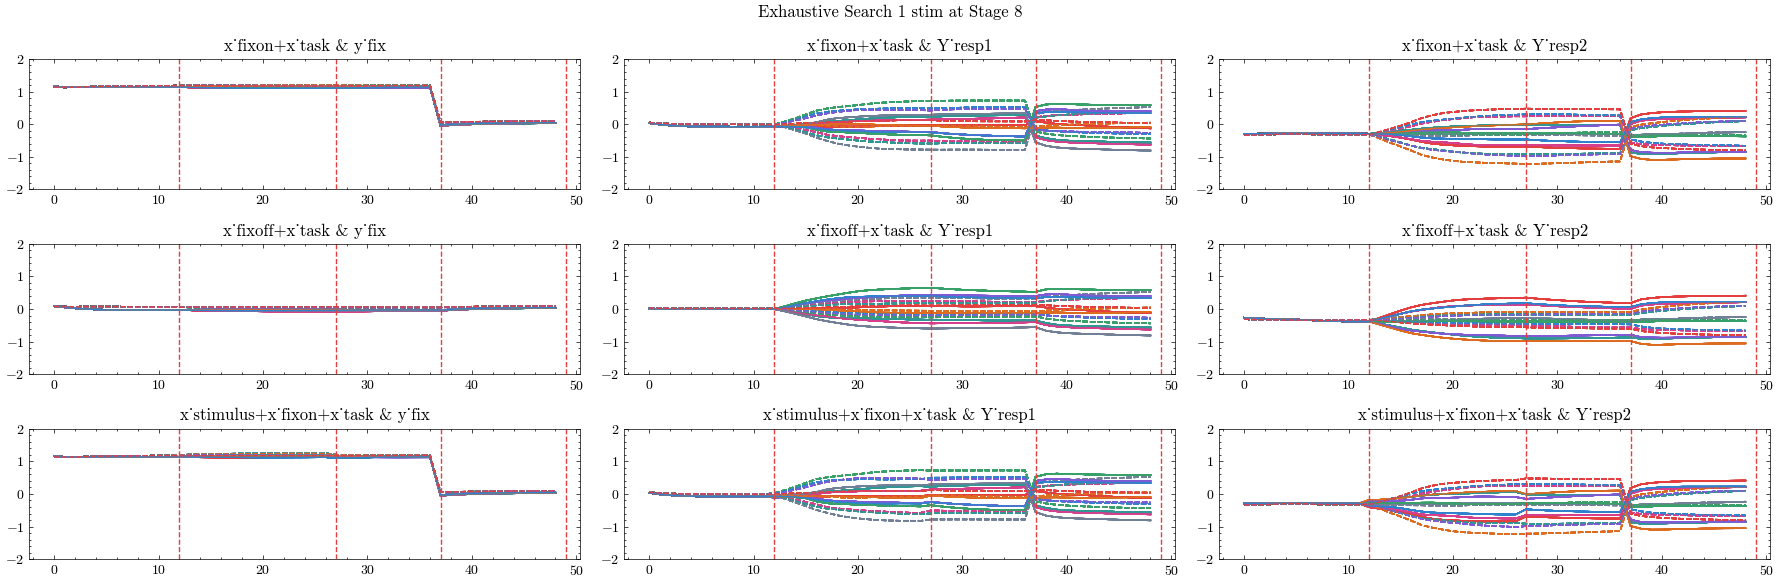

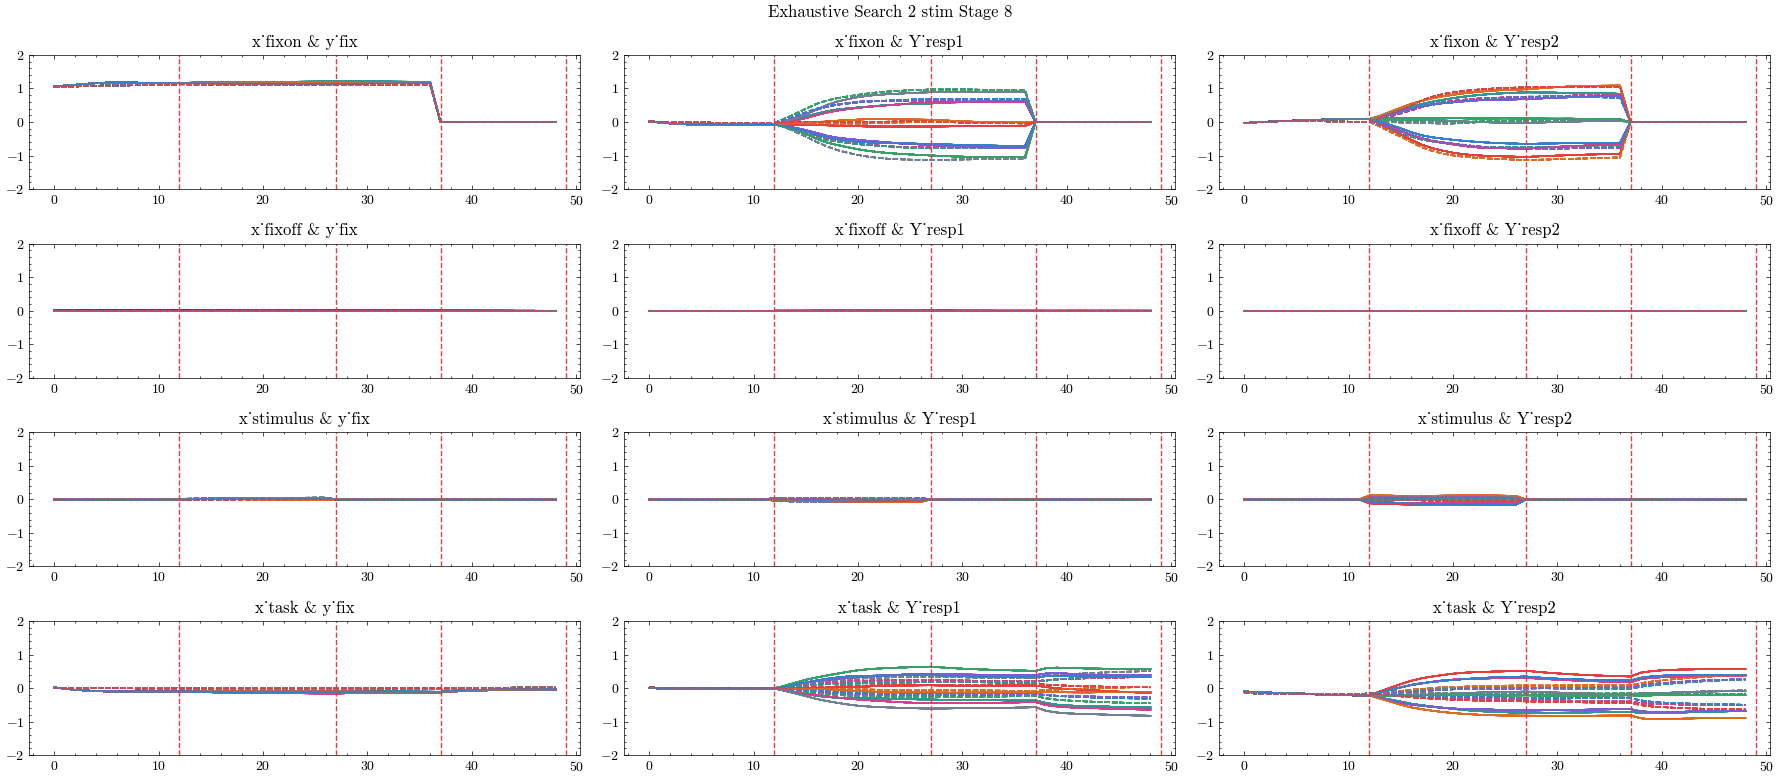

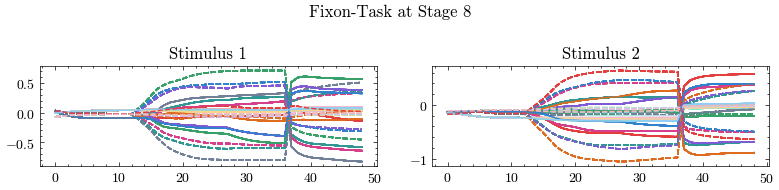

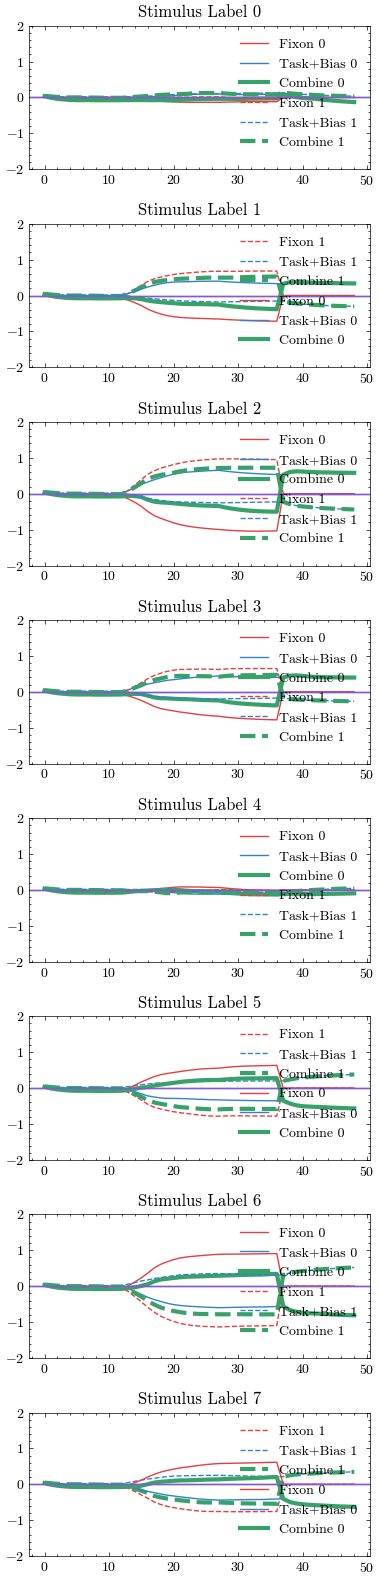

In [17]:
all_trajectory, all_trajectory_random = [], []
for stage_iter in range(stages_num):
    task_middle_dict, task_labels_across_batch, save_trajectory, save_trajectory_random = plot_trajectory_by_index(np.unique(labels), \
                                                                                                                    stage_iter, \
                                                                                                                    verbose=(stage_iter==stages_num-1)
                                                                                          )
    all_trajectory.append(save_trajectory)
    all_trajectory_random.append(save_trajectory_random)

/tmp/ipykernel_9198/1321299704.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,0], "-o", c=c_vals[0], linestyle=l_vals[0], label="abs(fixon-task) Task 0")
/tmp/ipykernel_9198/1321299704.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,1], "-o", c=c_vals[1], linestyle=l_vals[0], label="abs(fixon) Task 0")
/tmp/ipykernel_9198/1321299704.py:49: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,2], "-o", c=c_vals[2], linestyle=l_vals[0], label="abs(task) 

Text(0, 0.5, 'Projection Diff')

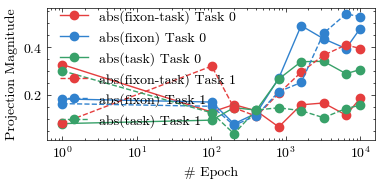

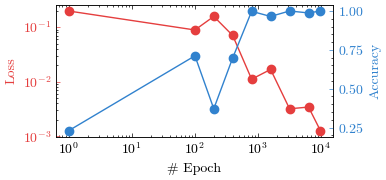

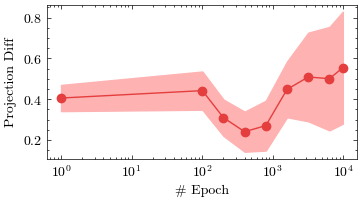

In [18]:
def analyze_trajectory(save_trajectory):
    """
    Analyze trajectories by calculating mean absolute values for fixations and tasks.
    """
    def process_trajectory(trajectory, ind=False):
        results = []
        for batch in trajectory:
            stim1_fixon = batch[0,1][stimulus_start:response_start]
            stim1_task = batch[3,1][stimulus_start:response_start]
            if ind: 
                bias = batch[4,1][stimulus_start:response_start]
            else:
                bias = np.zeros_like(stim1_fixon.shape)

            response_beh = batch[0,1][response_start:] + batch[3,1][response_start:] + batch[4,1][response_start:]

            # average over time 
            results.append([np.mean(np.abs(stim1_fixon + stim1_task + bias)), \
                            np.mean(np.abs(stim1_fixon)), np.mean(np.abs(stim1_task)), \
                            np.mean(np.abs(stim1_fixon + stim1_task + bias)), \
                            np.mean(np.abs(stim1_fixon)), np.mean(np.abs(stim1_task)), \
                            np.mean(response_beh)
                           ])
        return np.array(results)

    task_mask_0 = np.array(test_task) == 0 
    task_mask_1 = np.array(test_task) == 1
    
    # Process both trajectories
    result = process_trajectory(save_trajectory, True)

    response_cancel = []
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if lst == [k, 0]]
        ind2 = [i for i, lst in enumerate(label_task_comb) if lst == [k, 1]]
        response_mag = result[:,3]
        response_cancel.append(np.abs(np.mean(response_mag[ind1]) + np.mean(response_mag[ind2])))

    # Return the mean of the computed values
    return np.mean(result[:, 0][task_mask_0]), np.mean(result[:, 1][task_mask_0]), np.mean(result[:,2][task_mask_0]), \
            np.mean(result[:, 0][task_mask_1]), np.mean(result[:, 1][task_mask_1]), np.mean(result[:,2][task_mask_1]), \
            np.mean(response_cancel), np.std(response_cancel)

fixon_task_diff = np.array([analyze_trajectory(all_trajectory[i]) for i in range(len(all_trajectory))])

figfixontaskcancel, axsfixontaskcancel = plt.subplots(figsize=(4,2))
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,0], "-o", c=c_vals[0], linestyle=l_vals[0], label="abs(fixon-task) Task 0")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,1], "-o", c=c_vals[1], linestyle=l_vals[0], label="abs(fixon) Task 0")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,2], "-o", c=c_vals[2], linestyle=l_vals[0], label="abs(task) Task 0")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,3], "-o", c=c_vals[0], linestyle=l_vals[1], label="abs(fixon-task) Task 1")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,4], "-o", c=c_vals[1], linestyle=l_vals[1], label="abs(fixon) Task 1")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,5], "-o", c=c_vals[2], linestyle=l_vals[1], label="abs(task) Task 1")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,3], "-o", c=c_vals_l[0], label="abs(fixon-task) random")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,4], "-o", c=c_vals_l[1], label="abs(fixon) random")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,5], "-o", c=c_vals_l[2], label="abs(task) random")
axsfixontaskcancel.legend()
axsfixontaskcancel.set_ylabel("Projection Magnitude")
# axsfixontaskcancel.set_title("Average Cancellation Effect Before Response Period")

axsfixontaskcancel.set_xlabel("# Epoch")
axsfixontaskcancel.set_xscale("log")
figfixontaskcancel.tight_layout()
# figfixontaskcancel.savefig(f"./twotasks/cancel_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

fig, ax1 = plt.subplots(figsize=(4,2))  # Create a new figure

ax1.plot(counter_lst, loss_lst, "-o", c=c_vals[0], label="Loss")
ax1.set_ylabel("Loss", color=c_vals[0])
ax1.tick_params(axis='y', colors=c_vals[0])
ax1.set_yscale("log")  # Keep log scale for loss
ax1.set_xlabel("Counter")

# Create a second y-axis for accuracy (right)
ax2 = ax1.twinx()
ax2.plot(counter_lst, acc_lst, "-o", c=c_vals[1], label="Accuracy")
ax2.set_ylabel("Accuracy", color=c_vals[1])
ax2.tick_params(axis='y', colors=c_vals[1])

ax1.set_xlabel("# Epoch")
ax1.set_xscale("log")
fig.tight_layout()
# fig.savefig(f"./twotasks/loss_acc_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

figcancel, axcancel = plt.subplots(figsize=(4,2))
axcancel.plot(counter_lst, fixon_task_diff[:,6], "-o", c=c_vals[0], label="Cancel of Proj in Response")
axcancel.fill_between(counter_lst, fixon_task_diff[:,6] - fixon_task_diff[:,7], fixon_task_diff[:,6] + fixon_task_diff[:,7], color=c_vals_l[0])
axcancel.set_xlabel("# Epoch")
axcancel.set_xscale("log")
axcancel.set_ylabel("Projection Diff")
# figcancel.savefig(f"./twotasks/response_cancel_task_anti_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [19]:
def average_cosine_similarity(matrix):
    """
    """
    cos_sim_matrix = cosine_similarity(matrix)
    avg_similarity = np.nanmean(np.triu(cos_sim_matrix))
    
    return avg_similarity

In [20]:
def sample_upper_means(mat, k=8, n_iter=1000, seed=None):
    """
    """
    rng = np.random.default_rng(seed)

    # 1. Pull out only the finite (non-NaN) entries once.
    valid_vals = mat[~np.isnan(mat)].ravel()

    # 2. Sanity check.
    if valid_vals.size < k:
        raise ValueError(f"Need at least {k} finite values, got {valid_vals.size}")

    # 3. Repeat: sample k numbers → take their mean.
    means = np.array([
        rng.choice(valid_vals, size=k, replace=False).mean()
        for _ in range(n_iter)
    ])

    return [np.mean(means), np.std(means)]

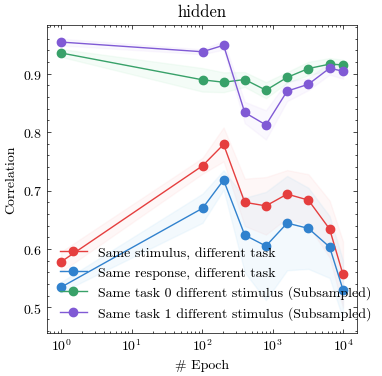

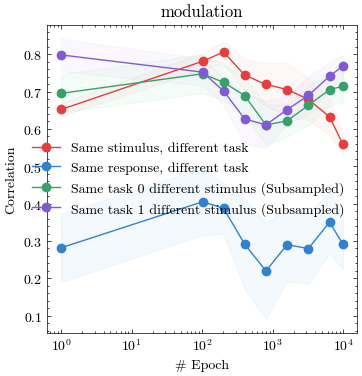

In [24]:
# modulation of fixon and task should be the same for each task specifically 
# regardless of the stimulus 
assert color_by == "stim" 

comparelst = ["hidden", "modulation"]

for compare in comparelst:
    all_result = [] 
    for stage_iter in range(stages_num):
        Woutput = Woutput_lst[stage_iter]
        W = Wall_lst[stage_iter][0]
        _, Ms_orig, hs, bs = modulation_extraction(db_lst[stage_iter], layer_index)
        inverse_modulation_ss_dt = []
        inverse_modulation_sr_dt = []
        inverse_modulation_st_ds = [[], []]
        modulation_save = [[],[]]
        modulation_fixp_end = [[],[]]
    
        # same stimulus (effectively anti-response), different task
        for k in range(8):
            ind1 = [i for i, lst in enumerate(label_task_comb) if lst == [k, 0]]
            ind2 = [i for i, lst in enumerate(label_task_comb) if lst == [k, 1]]
    
            if net_params["input_layer_add"]:
                win = net.W_initial_linear.weight.data.detach().cpu().numpy()
            else: 
                win = np.ones((7, 7))
            
            if compare == "modulation": 
                Ms1_change_stimulus = ((Ms_orig[ind1[0],stimulus_end,:,:]) @ win)[:,0].flatten()
                Ms2_change_stimulus = ((Ms_orig[ind2[0],stimulus_end,:,:]) @ win)[:,0].flatten()
            elif compare == "hidden": 
                Ms1_change_stimulus = hs[ind1[0],stimulus_end,:].flatten()
                Ms2_change_stimulus = hs[ind2[0],stimulus_end,:].flatten()
            
            inverse_modulation_ss_dt.append(1 - cosine(Ms1_change_stimulus, Ms2_change_stimulus))
    
            Ms1_fix_period_end = Ms_orig[ind1[0],stimulus_start-1,:,:][:,0]
            Ms2_fix_period_end = Ms_orig[ind2[0],stimulus_start-1,:,:][:,0]
    
            modulation_save[0].append(Ms1_change_stimulus)
            modulation_save[1].append(Ms2_change_stimulus)
    
            if k == 0: 
                modulation_fixp_end[0].append(Ms1_fix_period_end)
                modulation_fixp_end[1].append(Ms2_fix_period_end)
    
        # same response, different task 
        for k in range(8):
            ind1 = [i for i, lst in enumerate(label_task_comb) if lst == [k, 0]]
            ind2 = [i for i, lst in enumerate(label_task_comb) if lst == [(k + 4) % 8, 1]]
    
            if compare == "modulation": 
                Ms1_change_stimulus = ((Ms_orig[ind1[0],stimulus_end,:,:]) @ win)[:,0].flatten()
                Ms2_change_stimulus = ((Ms_orig[ind2[0],stimulus_end,:,:]) @ win)[:,0].flatten()
            elif compare == "hidden": 
                Ms1_change_stimulus = hs[ind1[0],stimulus_end,:].flatten()
                Ms2_change_stimulus = hs[ind2[0],stimulus_end,:].flatten()
            
            inverse_modulation_sr_dt.append(1 - cosine(Ms1_change_stimulus, Ms2_change_stimulus))
    
        # same task, different stimulus 
        modulation_matrices = [
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan), 
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan)
        ]
        for i in range(len(modulation_save[0])):
            for j in range(i+1, len(modulation_save[0])):
                modulation_matrices[0][i,j] = 1 - cosine(modulation_save[0][i], modulation_save[0][j]) 
                modulation_matrices[1][i,j] = 1 - cosine(modulation_save[1][i], modulation_save[1][j])
    
        fix_period_mod_diff = 1 - cosine(modulation_fixp_end[0][0], modulation_fixp_end[1][0])
    
        all_result.append([[np.mean(inverse_modulation_ss_dt), np.std(inverse_modulation_ss_dt)], \
                           [np.mean(inverse_modulation_sr_dt), np.std(inverse_modulation_sr_dt)], \
                           sample_upper_means(modulation_matrices[0], k=8, n_iter=10), \
                           sample_upper_means(modulation_matrices[1], k=8, n_iter=10)
        ])
    
    all_result = np.array(all_result)
    
    legends = ["Same stimulus, different task", "Same response, different task", \
               "Same task 0 different stimulus (Subsampled)", "Same task 1 different stimulus (Subsampled)"]
    
    figr, axsr = plt.subplots(1,1,figsize=(4,4))
    for i in range(all_result.shape[1]):
        axsr.plot(counter_lst, all_result[:,i,0], "-o", c=c_vals[i], label=legends[i])
        axsr.fill_between(counter_lst, all_result[:,i,0]-all_result[:,i,1], all_result[:,i,0]+all_result[:,i,1], \
                         color=c_vals_l[i], alpha=0.1)
    # axsr.plot(counter_lst, all_result[:,4], "-o", c=c_vals[5], label="Task 0/1 Modulation Diff End Fixon Period")
    axsr.legend()
    axsr.set_xlabel("# Epoch")
    axsr.set_xscale("log")
    axsr.set_ylabel("Correlation")
    axsr.set_title(compare)
    figr.savefig(f"./twotasks/compare_{compare}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300) 

Rule delaygo (idx 0)
Rule delayanti (idx 1)
Rule delaygo (idx 0)
Rule delayanti (idx 1)
Rule delaygo (idx 0)
Rule delayanti (idx 1)
Rule delaygo (idx 0)
Rule delayanti (idx 1)


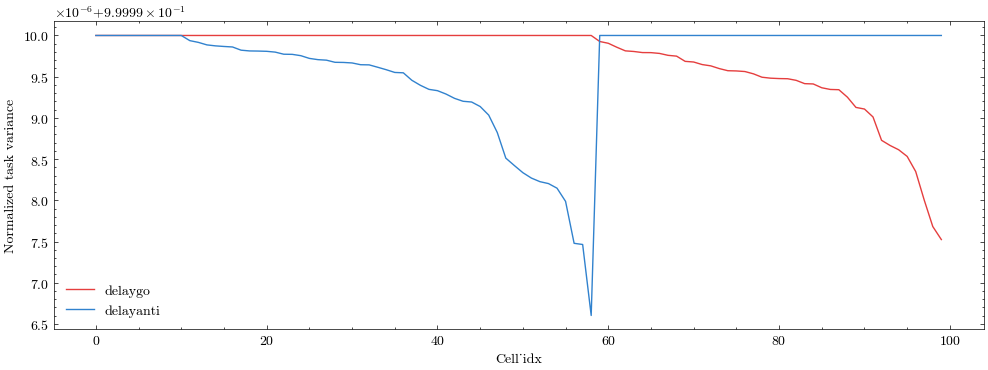

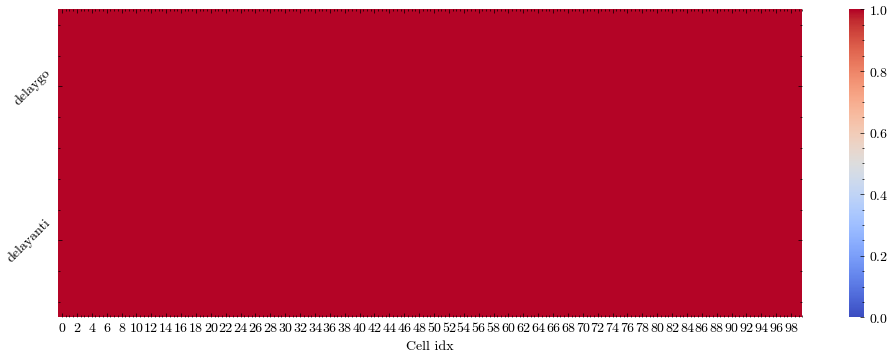

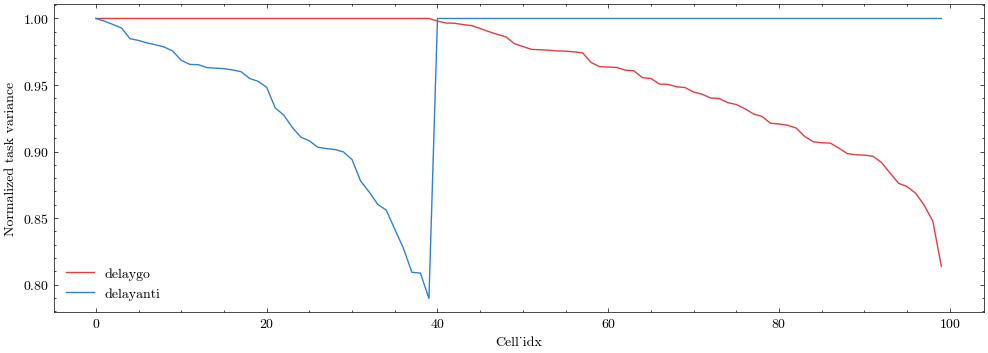

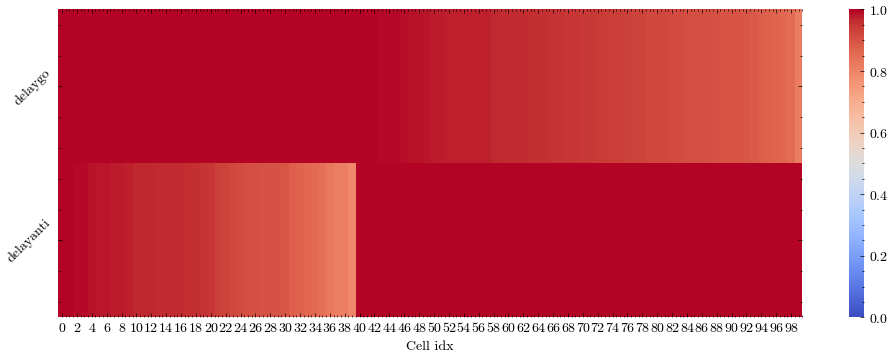

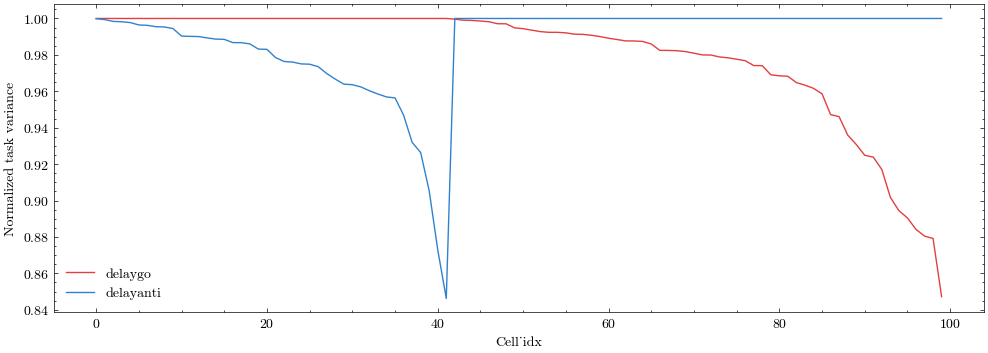

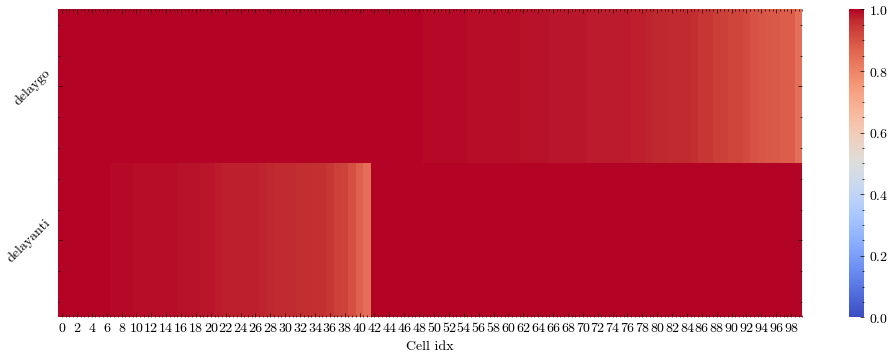

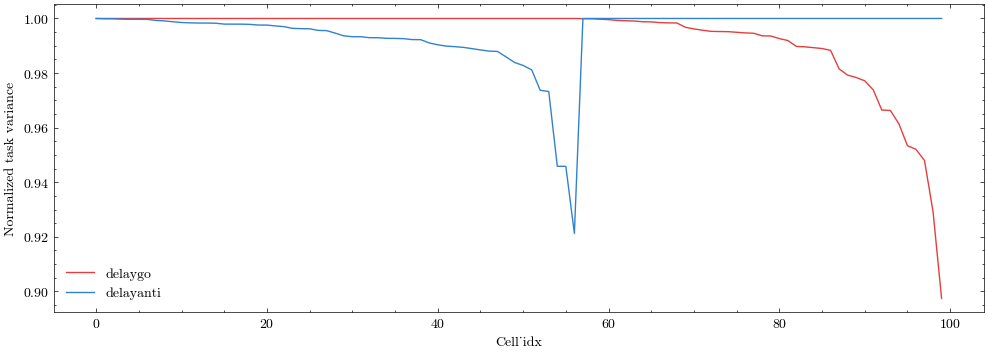

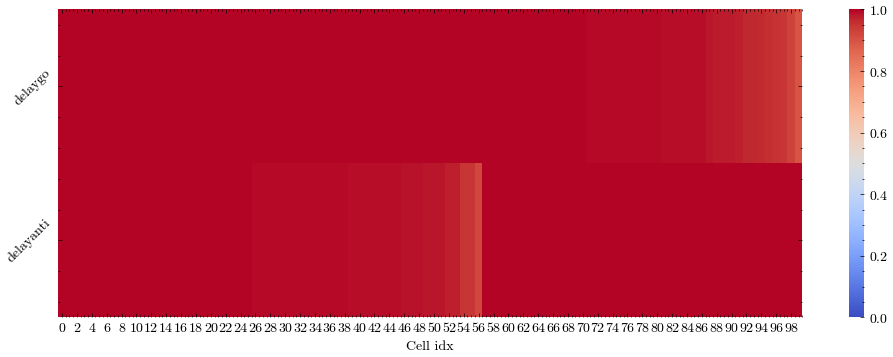

In [22]:
tb = all_breaks[0] 
tb.insert(0,0)

for el in range(len(tb)-1):
    
    cell_vars_tot = np.var(hs[:,tb[el]:tb[el+1],:], axis=(0, 1)) # Var over batch and sequence
    n_rules = len(task_params['rules'])
    n_cells = hs.shape[-1]
    
    cell_vars_rules = np.zeros((n_rules, n_cells,))
    cell_vars_rules_norm = np.zeros_like(cell_vars_rules)
    
    for rule_idx, rule in enumerate(task_params['rules']):
        print('Rule {} (idx {})'.format(rule, rule_idx))
        rule_hs = hs[test_rule_idxs == rule_idx, tb[el]:tb[el+1], :]
        cell_vars_rules[rule_idx] = np.var(rule_hs, axis=(0, 1)) 
    
    # normalize
    cell_max_var = np.max(cell_vars_rules, axis=0) # Across rules
    for rule_idx, rule in enumerate(task_params['rules']):
        cell_vars_rules_norm[rule_idx] = np.where(
            cell_max_var > 0., cell_vars_rules[rule_idx] / cell_max_var, 0.
        )
    
    # sort 
    if n_rules > 1:
        rule0_vals = cell_vars_rules_norm[0].tolist()
        rule1_vals = cell_vars_rules_norm[1].tolist()
    
    rule01_vals = np.array(list(zip(rule0_vals, rule1_vals)), dtype=[('rule0', float), ('rule1', float)])
    sort_idxs = np.argsort(rule01_vals, order=['rule0', 'rule1'])[::-1]
    
    cell_vars_rules_sorted_norm = cell_vars_rules_norm[:, sort_idxs]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for rule_idx, rule in enumerate(task_params['rules']):
        ax.plot(cell_vars_rules_sorted_norm[rule_idx], color=c_vals[rule_idx],
                label=task_params['rules'][rule_idx])
    
    ax.legend()
    ax.set_xlabel('Cell_idx')
    ax.set_ylabel('Normalized task variance')
    
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    sns.heatmap(cell_vars_rules_sorted_norm, ax=ax, cmap="coolwarm", cbar=True, vmin=0, vmax=1)
    ax.set_yticks(np.arange(n_rules) + 0.5)
    ax.set_yticklabels(task_params['rules'], rotation=45)
    ax.set_xlabel('Cell idx')

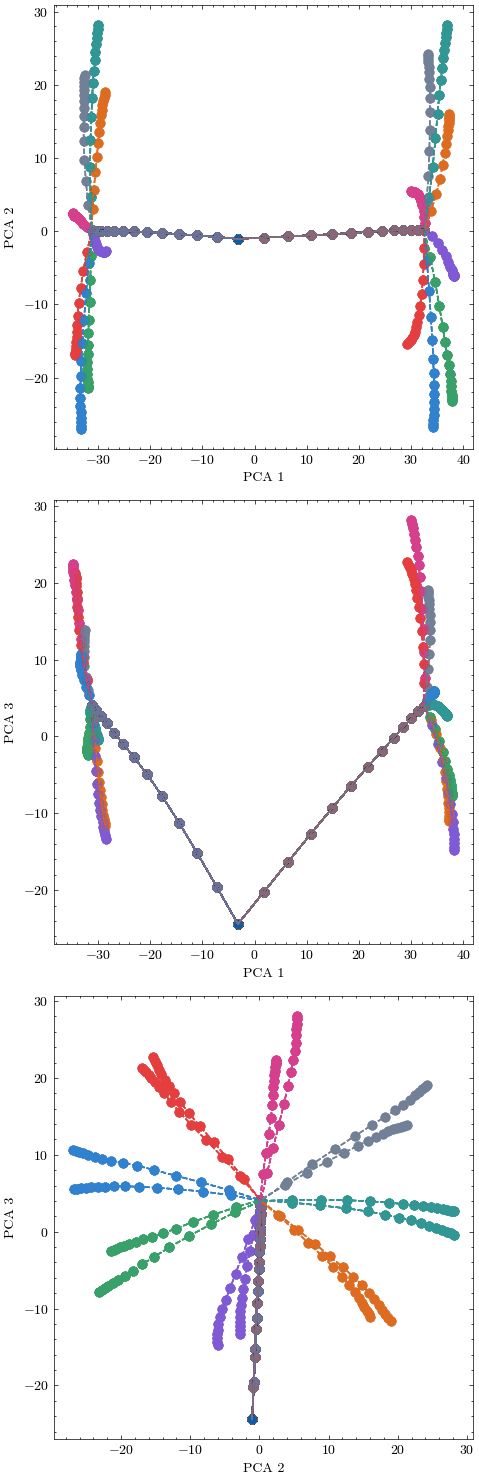

In [23]:
fighs, axshs = plt.subplots(3,1,figsize=(5*1,5*3))
axshs = np.atleast_2d(axshs).T
pca_er_stage = []

start_stage = stages_num - 1
for stage_iter in range(start_stage, stages_num):
    PCA_downsample = 3
    Ms, Ms_orig, hs, bs = modulation_extraction(db_lst[stage_iter], layer_index)

    pca = PCA(n_components = PCA_downsample)
    
    # Ms_end_of_stimulus = Ms_orig[np.array(test_task) == 0,stimulus_end:stimulus_end+1,:,:]
    # Ms_end_of_stimulus_flattened = Ms_end_of_stimulus.reshape(Ms_end_of_stimulus.shape[0] * Ms_end_of_stimulus.shape[1] * Ms_end_of_stimulus.shape[3], Ms_end_of_stimulus.shape[2])
    # pca.fit(Ms_end_of_stimulus_flattened)
    # Ms_flattened = Ms_orig.reshape(Ms_orig.shape[0] * Ms_orig.shape[1] * Ms_orig.shape[3], Ms_orig.shape[2])
    # projected_data = pca.transform(Ms_flattened)

    # Ms_reconstructed = projected_data.reshape(Ms_orig.shape[0], Ms_orig.shape[1], Ms_orig.shape[3], PCA_downsample)
    # lowd_data_lst = [Ms_reconstructed[:,:,0,:]] # for instance, modulation of fixon

    # from Kyle's previous code 
    n_activity = Ms.shape[-1] 
    activity_zero = np.zeros((1, n_activity,))

    as_flat = Ms.reshape((-1, n_activity))
    pca.fit(as_flat) 
    as_pca = pca.transform(as_flat)
    projected_data = as_pca.reshape((Ms.shape[0], Ms.shape[1], -1))
    zeros_pca = pca.transform(activity_zero)

    lowd_data_lst = [projected_data]
    
    for i in range(Ms_orig.shape[0]):
        for dd in range(len(lowd_data_lst)):
            lowd_data = lowd_data_lst[dd]
            data_batch = lowd_data[i,:,:]
            
            axshs[0,stage_iter-start_stage].scatter(data_batch[:stimulus_end,0], data_batch[:stimulus_end,1], marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.2)
            axshs[0,stage_iter-start_stage].plot(data_batch[:stimulus_start-1,0], data_batch[:stimulus_start-1,1], c=c_vals[labels[i,0]], linestyle=l_vals[0], alpha=0.2)
            axshs[0,stage_iter-start_stage].plot(data_batch[stimulus_start-1:stimulus_end,0], data_batch[stimulus_start-1:stimulus_end,1], c=c_vals[labels[i,0]], linestyle=l_vals[1], alpha=0.2)
            axshs[0,stage_iter-start_stage].scatter(zeros_pca[0,0], zeros_pca[0,1])
            axshs[0,stage_iter-start_stage].set_xlabel("PCA 1")
            axshs[0,stage_iter-start_stage].set_ylabel("PCA 2")
            
            axshs[1,stage_iter-start_stage].scatter(data_batch[:stimulus_end,0], data_batch[:stimulus_end,2], marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.2)
            axshs[1,stage_iter-start_stage].plot(data_batch[:stimulus_start-1,0], data_batch[:stimulus_start-1,2], c=c_vals[labels[i,0]], linestyle=l_vals[0], alpha=0.2)
            axshs[1,stage_iter-start_stage].plot(data_batch[stimulus_start-1:stimulus_end,0], data_batch[stimulus_start-1:stimulus_end,2], c=c_vals[labels[i,0]], linestyle=l_vals[1], alpha=0.2)
            axshs[1,stage_iter-start_stage].scatter(zeros_pca[0,0], zeros_pca[0,2])
            axshs[1,stage_iter-start_stage].set_xlabel("PCA 1")
            axshs[1,stage_iter-start_stage].set_ylabel("PCA 3")
            
            axshs[2,stage_iter-start_stage].scatter(data_batch[:stimulus_end,1], data_batch[:stimulus_end,2], marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.2)
            axshs[2,stage_iter-start_stage].plot(data_batch[:stimulus_start-1,1], data_batch[:stimulus_start-1,2], c=c_vals[labels[i,0]], linestyle=l_vals[0], alpha=0.2)
            axshs[2,stage_iter-start_stage].plot(data_batch[stimulus_start-1:stimulus_end,1], data_batch[stimulus_start-1:stimulus_end,2], c=c_vals[labels[i,0]], linestyle=l_vals[1], alpha=0.2)
            axshs[2,stage_iter-start_stage].scatter(zeros_pca[0,1], zeros_pca[0,2])
            axshs[2,stage_iter-start_stage].set_xlabel("PCA 2")
            axshs[2,stage_iter-start_stage].set_ylabel("PCA 3")

fighs.tight_layout()
# fighs.savefig(f"./twotasks/m_pca_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)